# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

In this project, we will work on a problem to predict salaries based on job descriptions. There are different factors on which salary depends like education of person, number of years of experience in industry, Designation in the company, type of industry etc. We will evaluate all the factors available in the data and create a model that will predict the salary based on all factors.

This model will help the Candidates to estimate their current salary and to predict new salary if they want to switch. On the other part, It will also help, companies in deciding the salaries for new hires.

In [1]:
__author__ = "Samit Singh"
__email__ = "samitsingh.85@gmail.com"

### Import necessary libraries

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')
import pickle

### Define data class for basic data gathering

In [3]:
class Data:
   
    def __init__(self, train_features, train_target, test_features, target_col):
        ''' This class is used to for basic tasks such as data load, merge.
            This class accepts following 4 input:
            train_features - path of file which contains features of training data
            train_target   - path of file which contains target of training data
            test_features  - path of which file contains features of test data
            target_col     - name of target column'''
        self.train_features = train_features
        self.train_target = train_target
        self.test_features = test_features
        self.target_col = target_col
        self.process_data()
                
    def process_data(self):
        self._create_train_df()
        self._create_test_df()
        self._find_column_info()
        self._print_train_stats()
        self._verify_invalid_data(self.train_df, self.target_col)
        self._verify_duplicate_data()
               
    def _create_train_df(self):
        ''' This method prepares Train data'''
        train_features_df = self._load_csv(train_features)
        train_target_df = self._load_csv(train_target)
        self.train_df = self._merge_df(train_features_df, train_target_df)
                
    def _create_test_df(self):
        ''' This method prepares Test data'''
        self.test_df = self._load_csv(test_features)
                        
    def _find_column_info(self):
        self.cat_cols = self._find_cat_cols(self.train_df)
        self.num_cols = self._find_num_cols(self.train_df)
                
    def _print_train_stats(self):
        print(' \n ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ Training Dataframe Information ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        self.print_stats(self.train_df)
        self.verify_nan(self.train_df)
        
    def _print_test_stats(self):
        print('\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Test Dataframe Information ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        self.print_stats(self.test_df)        
                
    def _load_csv(self, file):
        ''' This method will load csv file into a dataframe'''
        return pd.read_csv(file)
    
    def _merge_df(self, df1, df2):
        ''' This method will merge 2 dataframes '''
        return pd.merge(df1, df2)
 
    def print_stats(self, df):
        print('-------------------------------------------------')
        print('Shape of the Dataframe - {}'.format(df.shape))
        print('-------------------------------------------------')
        print('\n Dataframe information:- \n')
        print('\n{}'.format(df.info()))
        print('-------------------------------------------------')
        print(' Statistics of Numerical data:- \n \n{}'.format(df.describe()))
        print('-------------------------------------------------')
        print(' Statistics of Categorical data:- \n \n{}'.format(df.describe(include='O')))
        
    def verify_nan(self, df):
        '''This method verify the null values in a dataframe'''
        nan = np.sum(df.isna().sum())
        if nan == 0:
            print('\n\n :-- There are no Null values in the dataframe')
            #print('-------------------------------------------------------------------')
        else:
            print('Following columns have null values in dataframe\n\n{}' 
                  .format(df.isnull().sum()))
            # define imputation strategy accordingly

    def _find_cat_cols(self, df):
        '''This method finds the categorical columns in a dataset'''
        self.cat_cols = df.select_dtypes(include=['O']).columns.tolist()
        print('------------------------------------------------------------------------------------------------')
        print('List of all Categorical columns in data:- {}' \
                     .format(self.cat_cols))
        print('------------------------------------------------------------------------------------------------')
        return self.cat_cols
        
    
    def _find_num_cols(self, df):
        '''This method finds the numerical columns in a dataset'''
        num_cols = df.select_dtypes(exclude=['O']).columns.tolist()
        print('\nList of all Numerical columns in data:- {}' \
                     .format(num_cols))
        print('------------------------------------------------------------------------------------------------')
        return num_cols
        
    def _verify_invalid_data(self, df, cols):
        ''' This function is used to find invalid values in a single or mutiple columns of dataframe'''
        for col in [cols]:
            val_cnt = np.sum(df[col] <= 0)
            if val_cnt > 0:
                self.invalid_flag = True
                print('\n :-- There are {} invalid values are present in {} column'.format(val_cnt, col))

    
    def _verify_duplicate_data(self):
        '''This method will verify the duplicate data in a dataset'''
        print('\n :-- There are {} duplicate values are present in Train data'.format(self.train_df.duplicated().sum()))
        
        

### Define DrawPlot Class to explore insights of data through visualizations

In [25]:
class DrawPlot:
    
    sns.set(style="whitegrid")
    
    def __init__(self, data):
        self.data = data
        self.train_df = data.train_df
        self.target_col = data.target_col
        self.cat_cols = data.cat_cols
        self.num_cols = data.num_cols
        self.cor_cols = ['jobType_mean', 'degree_mean', 'major_mean', 'industry_mean', 'companyId_mean','yearsExperience', 'milesFromMetropolis',
                        'salary']
        self.target_col = data.target_col
        self._process_eda()       
    
    def _process_eda(self):
        self.DistPlot()
        self.BoxPlot()
        self.heatmap()

    def DistPlot(self):
        '''This method is used to plot the histogram of all numeric variables in dataframe'''
        fig = plt.figure(figsize=(14,14))
        for idx, col in enumerate(self.num_cols):
            fig.add_subplot(len(self.num_cols),len(self.num_cols), idx+1)
            sns.distplot(self.train_df[col], bins=20)
            plt.tight_layout()
#         plt.title('Distribution of Numerical columns', fontsize = 16)

    def BoxPlot(self):
        '''This method is used to plot the Boxen plots of all Categorical variables in dataframe'''
        df = self.train_df.copy()
        fig = plt.figure(figsize=(14,18))
        for idx, col in enumerate(self.cat_cols):
            if len(self.train_df[col].unique()) < 10 :
                df[col + '_mean'] = df.groupby(col)[self.target_col].transform('mean')
                fig.add_subplot(3,2, idx+1)
                sns.boxenplot(x = col, y=self.target_col, data=df.sort_values(col + '_mean'))
                plt.title('Comparison of salaries as per {}'.format(col), fontsize = 14)
                plt.tight_layout()
                plt.xticks(rotation=45)
                

    def heatmap(self):
        '''This method is used to plot the correlation between all numeric variables in dataframe'''
        df = self.train_df.copy()
        for col in self.cat_cols:
             if len(self.train_df[col].unique()) < 100:
                df[col + '_mean'] = df.groupby(col)[self.target_col].transform('mean')
        fig = plt.figure(figsize=(12,8))
        sns.heatmap(df[self.cor_cols].corr(), annot=True)
        plt.tight_layout()
        plt.title('Correlation Matrix', fontsize = 16)
        plt.xticks(rotation=45)
#         plt.yticks(rotation=30)


### Define Feature Engineering Class for data preprocessing

In [22]:
class FeatureEngg:
    '''This class will perform Feature Engineering such as Label Encoding, data cleaning, Impute missing values etc.'''
    def __init__(self, data):
        self.data = data
        self.target = data.target_col
        self.invalid_flag = data.invalid_flag
        self.function  = {'group_mean' :'mean', 'group_median':'median', 'group_max':'max', 'group_min':'min'}
        self.cat_cols = ['jobType', 'degree', 'major', 'industry', 'companyId']
        self.impute_cols = ['jobType', 'industry', 'degree', 'major']
        self.id_col = 'jobId'
        self._process_feature_engg()
    
    def _process_feature_engg(self):
        self._Feature_engg_train_df()
        self._Feature_engg_test_df()
        
    def _Feature_engg_train_df(self):
        if data.invalid_flag:
            self._clean_df()
        train_df = self._Label_Encoder(data.train_df, self.cat_cols)
        self.train_df = self.drop_cols(train_df, self.id_col)
        groupby_df = self._create_groupby(self.train_df, self.cat_cols)
        self.group_df = self._calc_group_stats(groupby_df, data.target_col)
        self.data.train_df = self._merge_groupby(self.train_df, self.group_df, self.cat_cols)
        
    def _Feature_engg_test_df(self):
        test_df = self._Label_Encoder(data.test_df, self.cat_cols, test_data=True)
        self.test_df = self.drop_cols(test_df, self.id_col)
        self.test_df  = self._merge_groupby(self.test_df, self.group_df, self.cat_cols)
        self.data.test_df = self._impute_nan(self.test_df, self.function)
           
    def _Label_Encoder(self, df, cols, test_data=False):
        ''' This method creates label encoding for categorical data'''
        for col in cols:
            le = LabelEncoder()
            if not test_data:
                le.fit(df[col])
            df[col] = le.fit_transform(df[col])
        return df    

    def drop_cols(self, df, cols):
        df = df.drop(columns=cols, axis=1)
        return df    

    def _clean_df(self):
        if self.invalid_flag:
            print('In this dataframe some invalid values are present in salary column. we need to drop those values \n')
            print('Shape of Dataframe before change:- {}'.format(data.train_df.shape))
            data.train_df = data.train_df[data.train_df['salary'] > 0]
            data.train_df.reset_index()
            print('Shape of Dataframe after dropping invalid rows:- {}'.format(data.train_df.shape, data.train_df.shape[0]))
           
    def _create_groupby(self, df, cols):
        df = df.groupby(cols)
        return df
   
    def _merge_groupby(self, df1, df2, keys):
        return pd.merge(df1,df2, on=keys, how='left')

    # Calculate group statistics of groups
    def _calc_group_stats(self, df, target):
        group_df = pd.DataFrame({'group_mean': df[target].mean()})
        group_df['group_median'] = df[target].median()
        group_df['group_max'] = df[target].max()
        group_df['group_min'] = df[target].min()
        group_df.reset_index(inplace=True)
        return group_df
        
    def _impute_nan(self, df, function):
        ''' There are some missing values present in test data in newly created features. From the correlation plot,
        we knew that, correaltion of company id & salary is very small. So, we have filled that missing values by
        taking group of other 4 columns. This imputer function is specifc to this project'''
        for col, func in  function.items():
            df[col] = df[col].fillna(df.groupby(self.impute_cols)[col].transform(func))
        return df
      

### Define Model Evaluation class to execute models and predict output

In [16]:
class Eval_Model:
    
    def __init__(self, data, models):
        self.data = data
        self.models = models
        self.mean_mse = {}
        self.best_model=None
        self.prediction=None
        self.base_target_df = data.train_df.group_mean
        self.target_df = data.train_df[data.target_col]
        self.feature_df = data.train_df.drop(data.target_col, axis=1)
        self.test_df = data.test_df 
        self._process_models()
        
    def _process_models(self):
        self._baseline_model()
        self.cross_validate_model()
        self.best_model_process()
        self.save_results()
        self.save_best_model
            
    def _baseline_model(self):
        '''For any baseline model, We can calculate the Mean of target, which is a good estimate.
        In this project, we had alreay calculated 'group_mean' of target, so, We have used the same for baseline model'''
        self.mean_mse['Baseline_model'] = mean_squared_error(self.target_df, self.base_target_df)
        
    def cross_validate_model(self, cv=3):
        for model in self.models:
            scores = cross_val_score(model, self.feature_df, self.target_df, cv=cv, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(scores)
                
    def best_model_process(self):
        '''This method will select the best model and perform fit on train data'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        self._print_model_stats()
        print('Fitting the Best Model.....')
        self.best_model.fit(self.feature_df, self.target_df)
        self._plot_feature_importance()
        print('Predicting using the Best Model')
        self.prediction = self.best_model.predict(self.test_df)
                
    def _print_model_stats(self):
        'This method will print the statistics of model'
        print('Models Statistics.......')
        for key, item in self.mean_mse.items():
            print('    \n Score of model {} :-'.format(key))
            print('\n          MSE - {}'.format(item))
        print('\n Best model is --------->\n\n {} :-'.format(self.best_model))
        print('\n          MSE - {}'.format(self.mean_mse[self.best_model]))
        
        
    def _plot_feature_importance(self):
        '''This method prints the feature importance used to train model'''
        features = self.feature_df.columns.to_list()
        importances = self.best_model.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=(8,8))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    def save_results(self):
        pd.merge(self.test_df, prediction)
        self.test.to_csv('submission.csv', index=False)        
    
    def save_best_model(self):
        '''This model save the best model to a file'''
        final_model = 'final_model.sav'
        pickle.dump(self.best_model, open(filename, 'wb'))
    
    @staticmethod
    def tune_hyperparameter(estimator, param_grid, n_iter=5, scoring='neg_mean_absolute_error', cv=5, n_jobs=-2, refit=False):
        ''' This method is used to find the hyperparameters used in models'''
        rs_cv = RandomizedSearchCV(estimator=estimator, param_distribution=param_grid, 
                                 n_iter=n_iter,
                                 cv=cv,
                                 n_jobs=n_jobs,
                                 refit=refit)
        rs_cv.fit(feature_df,target_df)
        return rs_cv.best_params_    


### ---- Defining parameters to instantiate classes ----

In [17]:
# Defining parameters to instantiate and load Data
train_features = './data/raw/train_features.csv'
train_target = './data/raw/train_salaries.csv'
test_features = './data/raw/test_features.csv'
target_col = 'salary'

### Create Data object and printed the basic statistics about the data

In [23]:
# create an instance of data object
data = Data(train_features, train_target, test_features, target_col)

------------------------------------------------------------------------------------------------
List of all Categorical columns in data:- ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
------------------------------------------------------------------------------------------------

List of all Numerical columns in data:- ['yearsExperience', 'milesFromMetropolis', 'salary']
------------------------------------------------------------------------------------------------
 
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ Training Dataframe Information ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
-------------------------------------------------
Shape of the Dataframe - (1000000, 9)
-------------------------------------------------

 Dataframe information:- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                10000

In [24]:
data.train_df.head()


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### Create plot object and instantiate it to visualize insight of data 

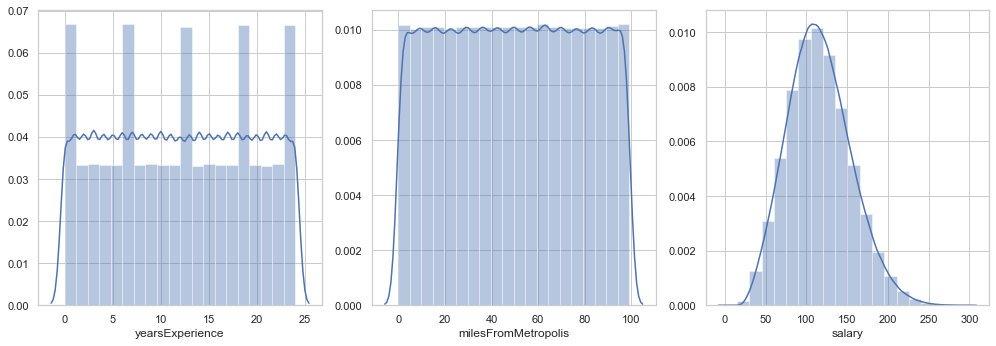

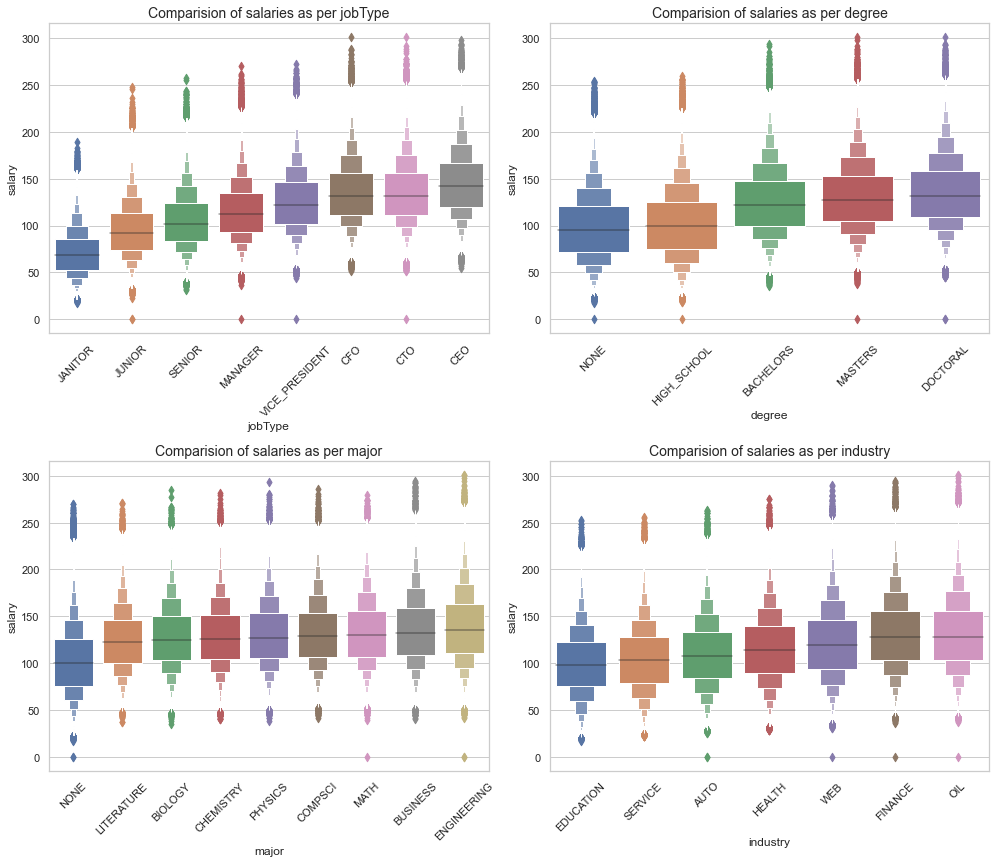

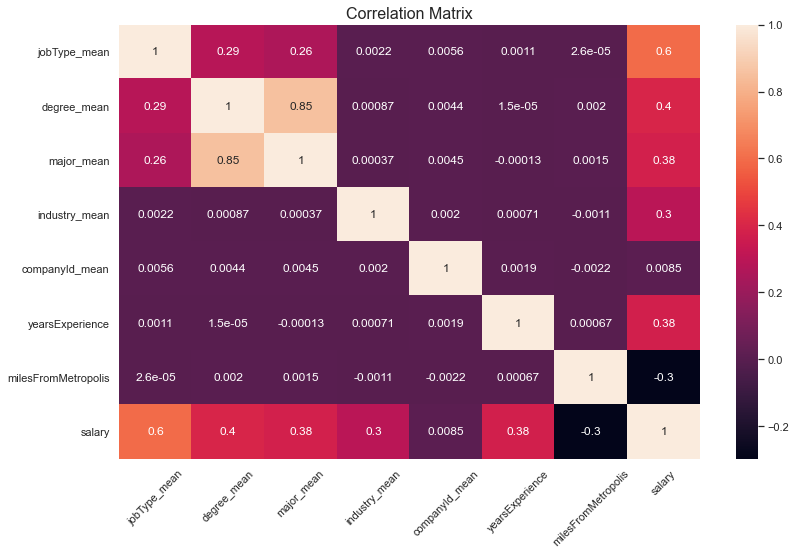

In [20]:
plot = DrawPlot(data)    
plot

Based on above statistics of Box plot, we observed that there are some invalid values are present in salary column i.e minimum value is zero.  

According to above correlation matrix, mean salary of JobType column is highly correlated to salary, followed by degree_mean, major_mean, Years Experience and industry. The Mile from Metropolis is negatively correlated to salary.

### ---- 3 Clean the data ----

In [26]:
#here we will do some feature engineering 
Feature_engineering = FeatureEngg(data)


In this dataframe some invalid values are present in salary column. we need to drop those values 

Shape of Dataframe before change:- (1000000, 9)
Shape of Dataframe after dropping invalid rows:- (999995, 9)


In [64]:
data.train_df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_median,group_max,group_min,distance
0,31,1,3,6,3,10,83,130,130.875000,136.0,150,98,133.57522
1,11,0,2,7,6,3,73,101,138.031250,132.0,204,90,117.48182
2,48,7,1,8,3,10,38,137,142.000000,137.0,173,116,61.15492
3,32,5,1,2,0,8,17,142,129.000000,131.0,169,77,27.35878
4,60,7,0,8,2,8,16,163,153.583333,141.5,232,94,25.74944


### ---- 4 Explore the data (EDA) ----

In [14]:
#

### ---- 5 Establish a baseline ----

In [19]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [20]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [13]:
#here we will do some feature engineering 
# Feature_engineering = FeatureEngg(data)


In [65]:
# verify if all data processed correctly, 
data.train_df.isna().sum() # mean has all Nulls, something is wrong

companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
group_mean             0
group_median           0
group_max              0
group_min              0
distance               0
dtype: int64

In [24]:
data.test_df.isna().sum()

companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
group_mean             0
group_median           0
group_max              0
group_min              0
dtype: int64

In [16]:
# from lightgbm import LGBMRegressor
# estimator = LGBMRegressor(colsample_bytree= 0.8,
#                              max_depth=-1, 
#                              n_estimators = 2000,
#                              num_leaves= 15,
#                              subsample= 1.0)
                             
# #310.78586015887294 - check if overfitting

In [18]:
# from lightgbm import LGBMRegressor
# estimator = LGBMRegressor(colsample_bytree= 0.6453922495343557,
#                              max_depth=5, 
#                              n_estimators = 1104,
#                              num_leaves= 63,
#                              subsample= 0.7380161818204857)
# 312.1330258504188

Models Statistics.......
    
 Score of model Baseline_model :-

          MSE - 644.2563251928312
    
 Score of model LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=15, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0) :-

          MSE - 310.6929330331583

 Best model is --------->

 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=15, objective=None,
              random_state=None, reg_alpha=0.0, reg_lam

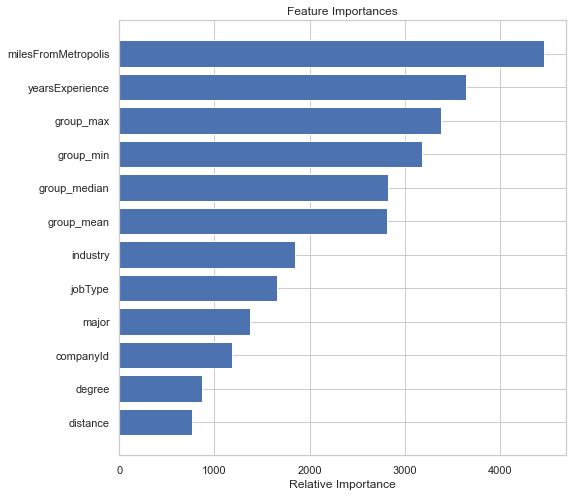

Predicting using the Best Model


In [66]:
lr = LinearRegression()
etr = ExtraTreesRegressor(n_estimators=40, max_depth=12, min_samples_split=2,  min_samples_leaf=2,random_state=42)
#rfr = RandomForestRegressor(n_estimators=40, max_depth=12, min_samples_split=2,  min_samples_leaf=2, random_state=42)
lgbm = LGBMRegressor(colsample_bytree= 0.8, max_depth=-1, n_estimators = 2000, num_leaves= 15, subsample= 1.0)

# models = [lr, etr, lgbm]
models = [lgbm]

model = Eval_Model(data, models)

# 310.66501188806564 - with location
# 310.73069003500126 - with exp

In [91]:
# from sklearn.model_selection import train_test_split
# train_feature_df, test_feature_df, train_target_df, test_target_df = train_test_split(model.feature_df, model.target_df,
#                                                                                      test_size=0.5, random_state=42)

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model.best_model, model.feature_df, model.target_df, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
plt.figure(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=model.feature_df.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

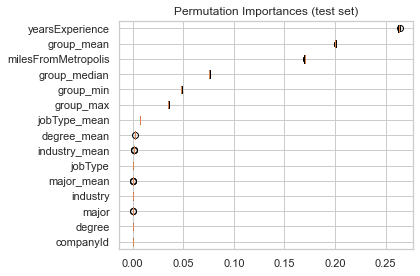

In [70]:
# from sklearn.inspection import permutation_importance
# result = permutation_importance(etr, X_test, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx = result.importances_mean.argsort()
# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()

### ---- 8 Create models ----

In [35]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [36]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [37]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [38]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [39]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data